In [2]:
# Shared memory can not be accessed by all possible threads, it is only available to all threads on specific SMs (Streaming multiprocessors) or blocks.
# By taking advantage of shared memory we can optimise our processes (it is up to 10x faster).
# Typically speed at which we access memory is extremely important as it is a big bottleneck.

import os,math,sys,torch,re,numpy as np
from types import SimpleNamespace as ns
from collections import namedtuple
import torch
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

# Below are highly important utilities that we can use for the rest of the course
# Here we load in an image, set its figure size and permute the dimensions since matplotlib uses a different format
def show_img(x, figsize=(4,3), **kwargs):
    "Display HW or CHW format image `x`"
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

# We can define the cuda begin with all basic utilities that are generally used in most scripts this cuda_begin can be attached
# First we add all the necessary imports using #include, e.g #include <torch/extension.h>
# including our cuda exception C10_CUDA_KERNEL_LAUNCH_CHECK - should be used after creating each kernel to check that it has been properly initialised

# Then we define CHECK_CUDA(x) CHECK_CONTIGUOUS(x) and CHECK_INPUT which just combines both of these prior macros
# In order to use any input we have to make sure that the memory is stored in cuda memory and contiguous

# cdiv used for ceiling division of a over b to calculate how many blocks we need - loaded to __host__ and __device__ and executed on these
# load_cuda uses load_inline which will save the inline cuda code and all functions chosen to a c++ file and compile it, it will then load it as a python module
# gpuAssert if we have an error in the cuda code then assert / print an error otherwise ignore it
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)
#define CUDA_ERR(ans) { gpuAssert((ans), __FILE__, __LINE__); }

inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

__host__ __device__ inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a+b-1)/b;}
'''

def load_cuda(cuda_src, cpp_src, funcs, opt=True, verbose=False, name=None):
    "Simple wrapper for torch.utils.cpp_extension.load_inline"
    if name is None: name = funcs[0]
    flags = "-O3 -Xptxas -O3 -Xcompiler -O3" if opt else "-O0 -Xptxas -O0 -Xcompiler -O0"
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=[flags], verbose=verbose, name=name)

def cdiv(a,b):
    "Int ceiling division of `a` over `b`"
    return (a+b-1)//b

In [3]:
# dim3 by using implicit defaults allows us to have 2d arrays as the third dimension will be 1 by default
dim3 = namedtuple('dim3', ['x','y','z'], defaults=(1,1))

In [5]:
d = dim3(
    5,5)
d

dim3(x=5, y=5, z=1)

In [7]:
d.x,d.y,d.z

(5, 5, 1)

In [8]:
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [9]:
sys.path.insert(0, '..')

In [17]:
# Printing for cuda
%load_ext wurlitzer
%reload_ext wurlitzer

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [18]:
# Cuda launch blocking is helpful for debugging hence not necessary for this memory instance
# os.environ['CUDA_LAUNCH_BLOCKING']='1'
torch.manual_seed(42);

In [22]:
# Starting by implementing the kernels in pure python
m1 = torch.rand(5120, 256)
m1s = m1[:4]
m2 = torch.rand(256,5120)
m2s = m2[:,:4]

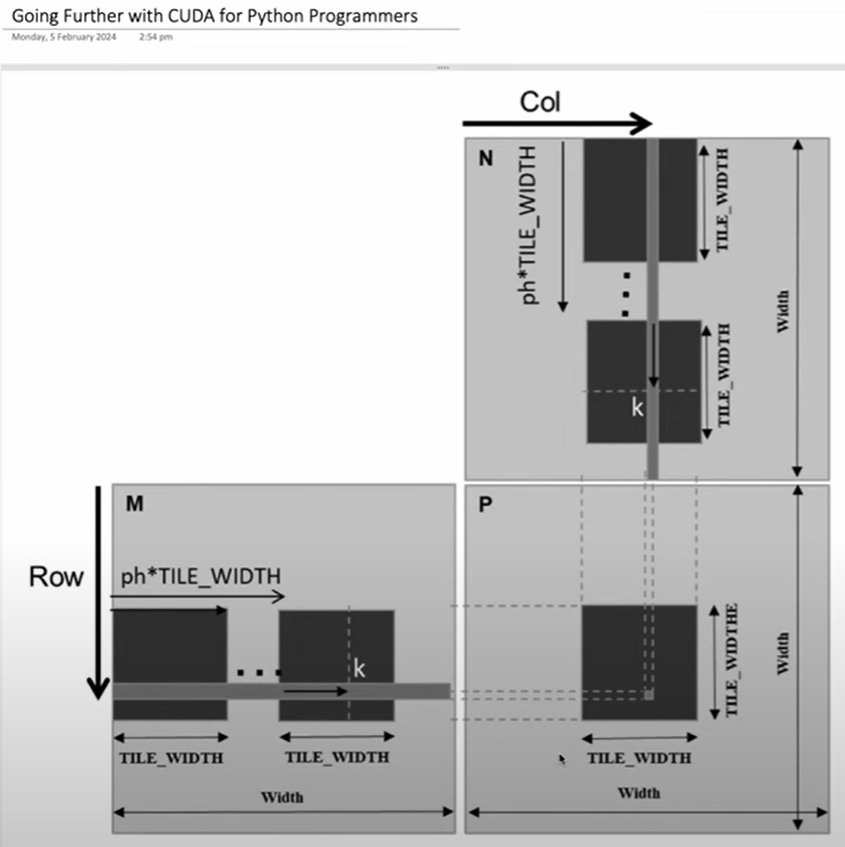

### 2d Python kernel

In [20]:
# 2D kernel runner that loops through the block and thread rows and columns as shown by the image
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x): f(dim3(i1,i0), dim3(j1,j0), threads, *args)

In [23]:
# This is the kernel code that will calculate what position we are in
# Including guard blocks
def matmul_bk(blockIdx, threadIdx, blockDim, m, n, out, h, w, k):
    r = blockIdx.y*blockDim.y + threadIdx.y
    c = blockIdx.x*blockDim.x + threadIdx.x
    
    if (r>=h or c>=w): return
    o = 0.
    for i in range(k): o += m[r*k+i] * n[i*w+c]
    out[r*w+c] = o

In [30]:
def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = dim3(16,16)
    blocks = dim3(cdiv(w,tpb.x), cdiv(h,tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [31]:
torch.isclose(matmul_2d(m1s, m2s), m1s@m2s).all()

tensor(True)

### CUDA

In [32]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [33]:
fname = 'matmul'

In [34]:
def get_sig(fname, src):
    res = re.findall(rf'^(.+\s+{fname}\(.*?\))\s*{{?\s*$', src, re.MULTILINE)
    return res[0]+';' if res else None

In [35]:
cpp_src = get_sig(fname, cuda_src)
cpp_src

'torch::Tensor matmul(torch::Tensor m, torch::Tensor n);'

In [36]:
module = load_cuda(cuda_src, cpp_src, [fname])

## Shared memory in CUDA

The problem is that in the loop we are reading from global CUDA memory when we do m[r*k + i] aswell as the indexing for the n array
However we can't just dump the entire matrix in memory for every single block, it will be far too much for the GPU to handle.

We have to tile our data, e.g a tile_width and load it into memory - we calculate the matrix multiplication (dot product) within those tiles, they have to keep being added up to get our result. Doing exactly the same thing but rather than all at once simply tiled.
The final tile will not be full

However rather than doing the first bit of a row and thus having to store multiple rows we can keep one row in one of the matrices constant.
The first column of a tile being already stored in shared memory does not have to be loaded from global memory.

We will put a whole tile into shared memory and the entire dot product can be put into shared memory.


In [40]:
# Now we can try to replicate what cuda does with shared memory
# Dynamic shared memory - we tell cuda how much shared memory we want in one contiguous block that we have a pointer to
# we can grab from that block any of the pieces that we want from that dynamic shared memory
a = torch.zeros(5)
# These are views of the first 3 elements and the last 2 elements
b,c = a[:3],a[3:]

# Now altering these views will change the actual values - this is exactly like having a pointer in c
b[1] = 2
c[0] = 6
a

tensor([0., 2., 0., 6., 0.])

In [41]:
# Copy all of our input into shared memory and take the dot product are the two steps we need
# Shared memory kernel runner will need to have shared memory between each block
def blk_kernel2d_shar(f, blocks, threads, sh_sz, *args, **kwargs):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            # All threads will have access to shared memory
            shared = torch.zeros(sh_sz)
            f(dim3(i1,i0), threads, shared, *args, **kwargs)

In [42]:
# Our first share size bits are the M matrix shared memory and the last shared size is the N matrix shared memory
def matmul_tiled_bk(blockIdx, blockDim, shared, m, n, out, h, w, k, tw):
    shar_sz = tw*tw
    ms,ns = shared[:shar_sz],shared[shar_sz:]
    
    # We then calculate the ph (index of tile we are up to)
    # For each tile (the ceil) of the size of our k dimension (number of columns in m) or rows in N and this will say how many tiles will fit
    # If we have done ph tiles each has jumped ph * tile_width which is exactly where our value starts
    for ph in range(cdiv(k,tw)):
        # This is hte index of where our tiles start and where our answer in the outupt layer will be too (since they are symmetrical)
        idx = ph*tw
        # Calculate what row and column we are in so that we can fill in our shared data (the size of the tiles)
        for tr in range(blockDim.y):
            for tc in range(blockDim.x):
                # Here we calculate the row and columns we are in based on the current tile row and tile column (inside our tile)
                # Plus the current tile that is tiling the entire matrix (using tile width * tile row) + tile column
                r,c = blockIdx.y*blockDim.y + tr, blockIdx.x*blockDim.x + tc
                # The final tiles we need to return 0 padding that will not be calculated when the tile does not match the size
                ms[tr*tw+tc] = m[ tc+idx + r*k] if r<h and idx+tc<k else 0.
                ns[tr*tw+tc] = n[(tr+idx)*w +c] if c<w and idx+tr<k else 0.
        
        # Now that we have shared memory we have to go through the tiles and aggregate all the bits of our dot product
        # Dot products from the shared data - always betwen tile_width on rows and columns - this is the size of the block
        for tr in range(blockDim.y):
            for tc in range(blockDim.x):
                # Then we find the row and column based on th block id and block dimension + the thread we are on
                r,c = blockIdx.y*blockDim.y + tr, blockIdx.x*blockDim.x + tc
                for i in range(tw):
                    if r*w+c<len(out): out[r*w+c] += ms[tr*tw+i] * ns[tw*i+tc]

In [43]:
# Running it is exactly the same, we call our shared memory runner and we passs in teh total shared memory
# Tile width * tile width is the size of each tile - but we need two of those one for each matrix tiled - this is the total shared memory we need
def matmul_2d(m, n, tw=16):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = dim3(tw,tw)
    blocks = dim3(cdiv(w,tpb.x), cdiv(h,tpb.y))
    blk_kernel2d_shar(matmul_tiled_bk, blocks, tpb, tw*tw*2,
                      m.flatten(), n.flatten(), output.flatten(),
                      h, w, k, tw=tw)
    return output

In [44]:
m1s.shape, m2.shape

(torch.Size([4, 256]), torch.Size([256, 5120]))

In [45]:
torch.isclose(matmul_2d(m1s, m2s, tw=16), m1s@m2s).all()

tensor(True)

### Python run_threads

In [ ]:
# Run threads will run a function that we pass to it for the given block size which will contain all the threads that we are running
def run_threads(f, blockDim, *args, **kwargs):
    for i0 in range(blockDim.y):
        for i1 in range(blockDim.x): 
            f(i0, i1, *args, **kwargs)

In [ ]:
# Now our tiled matric multiplication block still takes our shared data then
# get_rc will return our row and column that we are on given our row and column
# fill_shared_tk will will get the row and column and based on that will fill the entire shared memory we have to do taht for M and N matrix
def matmul_tiled_bk(blockIdx, blockDim, shared, m, n, out, h, w, k, tw):
    shar_sz = tw*tw
    ms,ns = shared[:shar_sz],shared[shar_sz:]

    def get_rc(tr, tc): return blockIdx.y*blockDim.y + tr, blockIdx.x*blockDim.x + tc

    def fill_shared_tk(tr, tc, ph):
        r,c = get_rc(tr, tc)
        ms[tr*tw+tc] = m[ tc + ph*tw + r*k] if r<h and (ph*tw+tc)<k else 0.
        ns[tr*tw+tc] = n[(tr + ph*tw)*w +c] if c<w and (ph*tw+tr)<k else 0.
    
    # This dot product will get the row and column taht we are on and for the entire thredads dimension it will multiply the values on the M row * N col
    # out [r*w + c] = ms[tr*tw + i]
    def dotprod_tk(tr, tc):
        r,c = get_rc(tr, tc)
        for i in range(tw):
            if r*w+c<len(out): out[r*w+c] += ms[tr*tw+i] * ns[tw*i+tc]
    
    # Then we run these two functions for all threads - we first fill it and then we do the dot product (This is done by going through each block)
    for ph in range(int(math.ceil(k/tw))):
        run_threads(fill_shared_tk, blockDim, ph)
        run_threads(dotprod_tk, blockDim)
        
# In CUDA a block is a conceptual thing that the programming model provides
# CUDA does not have loops, the functions that we run are conceptually all running at the same time - because they all share the same threads in the SM

In [ ]:
# Same code as we used before, we simply just run the shared kernel with our data that has been completely flattened
# we are using a dim3 but because the third dimension is implicit it will default to a size of 1
def matmul_2d(m, n, tw=16):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = dim3(tw,tw)
    blocks = dim3(cdiv(w,tpb.x), cdiv(h,tpb.y))
    blk_kernel2d_shar(matmul_tiled_bk, blocks, tpb, tw*tw*2,
                      m.flatten(), n.flatten(), output.flatten(),
                      h, w, k, tw=tw)
    return output

In [ ]:
m1s.shape, m2s.shape

(torch.Size([4, 256]), torch.Size([256, 4]))

In [ ]:
torch.isclose(matmul_2d(m1s, m2s, tw=16), m1s@m2s).all()

tensor(True)

### Python threads

In [ ]:
import threading
from threading import Barrier, Thread
from concurrent.futures import ThreadPoolExecutor

In [ ]:
def g(x, sb):
    print(x)
    sb.wait()
    print(-x)
    sb.wait()
    print(x*10)

In [ ]:
num = 3
sb = Barrier(num)
# This makes sure that the threads do the fill task then the dot product task
with ThreadPoolExecutor(num) as ex: list(ex.map(lambda i: g(i,sb), range(1,num+1)))

1

2

3

-3

-1

-2

30

20

10


In [ ]:
# The synchronisadtion barrier will create a bunch of threads
# The function called is the target f that we chose to run
def blk_kernel2d_shar(f, blocks, tpb, sh_sz, *args, **kwargs):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            shar = torch.zeros(sh_sz)
            syncb = Barrier(tpb.y*tpb.x)
            threads = [Thread(target=f, args=(dim3(i1,i0), dim3(p,o), tpb, shar, syncb, *args), kwargs=kwargs)
                       for o in range(tpb.y) for p in range(tpb.x)]
            for tr in threads: tr.start()
            for tr in threads: tr.join()

In [ ]:
def matmul_tiled_bk(blockIdx, threadIdx, blockDim, shared, syncb, m, n, out, h, w, k, tw):
    tc,tr = threadIdx.x,threadIdx.y
    r = blockIdx.y*blockDim.y + tr
    c = blockIdx.x*blockDim.x + tc

    shar_sz = tw*tw
    ms,ns = shared[:shar_sz],shared[shar_sz:]

    p = 0.
    for ph in range(cdiv(k,tw)):
        ms[tr*tw+tc] = m[ tc + ph*tw + r*k] if r<h and (ph*tw+tc)<k else 0.
        ns[tr*tw+tc] = n[(tr + ph*tw)*w +c] if c<w and (ph*tw+tr)<k else 0.
        # We have to sync to make sure that all threads have set the shared vvalues
        syncb.wait()
        for i in range(tw): p += ms[tr*tw+i] * ns[tw*i+tc]
        # This is also important otherwise some threads would start updating shared memory after theyre finished whilst some other threads will still be trying to do the dot product
        syncb.wait()

    if (r<h and c<w): out[r*w + c] = p

In [ ]:
def matmul_2d(m, n, tw=16):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = dim3(tw,tw)
    blocks = dim3(cdiv(w,tpb.x), cdiv(h,tpb.y))
    blk_kernel2d_shar(matmul_tiled_bk, blocks, tpb, tw*tw*2,
                      m.flatten(), n.flatten(), output.flatten(),
                      h, w, k, tw=tw)
    return output

In [ ]:
torch.isclose(matmul_2d(m1s, m2s, tw=8), m1s@m2s).all()

tensor(True)

### CUDA dynamic shared

In [ ]:
# This is the cuda equivalent
# we are using float arrays for our input and output matrices
# We keep track of blockIdx and blockDim that is already provided to us

# Shared memory in cuda is not passed in we just have to do extern __shared__ float ms[]; Memory shared
# extern __shared__
# we want our float *ns to point to the second half of the shared memory so we do &ms[tw * tw] which will go one full tile width through

# __syncthreads() will wait until all threads are finished doing the previous lines of code
# __syncthreads() they are already built in to cuda so we don't have to create them

# C++ templates can be used for tile width instead of normal parameters , they have to be called for for different versions of tile widths
# It is a variable that can be replaced dynamically instead

# Cuda cannot optimise code for a range of different tile widths so this is a problem - ms[tr*tw + i] * ns[tw*i + tc] we have to use templates instead
# Optimised kernels for a range of different hardware is difficult
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float *m, float *n, float *out, int h, int w, int k, int tw) {
    int tc=threadIdx.x, tr=threadIdx.y;
    int r=blockIdx.y*blockDim.y+tr, c=blockIdx.x*blockDim.x+tc;

    extern __shared__ float ms[];
    float *ns = &ms[tw*tw];

    float p = 0.0f;
    for (int ph = 0; ph < cdiv(k,tw); ++ph) {
        int idx = ph*tw;
        ms[tr*tw + tc] = r<h && idx+tc<k ? m[ tc+idx + r*k ] : 0.0f;
        ns[tr*tw + tc] = c<w && idx+tr<k ? n[(tr+idx)*w + c] : 0.0f;
        __syncthreads();
        for (int i=0; i<tw; ++i) p += ms[tr*tw + i] * ns[tw*i + tc];
        __syncthreads();
    }
    if (r<h && c<w) out[r*w + c] = p;
}
'''

In [ ]:
# Here the third a rgument that we passs into teh kernel running is the amount of shared memory that it will create
# Static we can set our tile width to 16 for example which will be 16*16*2*sizeof(float) total bytes of shared memory that we need

# The basic idea of dynamic size calculation is to get device properties which will return the number of max threads that we have per block
# It will also give the max shared mem per block we can have tw to be the sqrt of maxThreads so that we can maximise them
# it will also be limited by the max size of the required size
cuda_src += r'''
torch::Tensor matmul_dyn(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h=m.size(0), w=n.size(1), k=m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    /*
    // Commented out section demonstrating basic idea of dynamic size calculation
    cudaDeviceProp devProp;
    CUDA_ERR(cudaGetDeviceProperties(&devProp, 0));
    int maxThreads = devProp.maxThreadsPerBlock;
    size_t requiredSize = static_cast<size_t>(maxThreads) * 2 * sizeof(float);
    size_t size = min(devProp.sharedMemPerBlock, requiredSize);
    int TW = std::sqrt(maxThreads);
    */

    // We just set size fixed for now
    int TW = 16;
    size_t size = TW*TW * 2 * sizeof(float);
    dim3 tpb(TW,TW);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks,tpb,size>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k, TW);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [ ]:
fname = 'matmul_dyn'

In [ ]:
cpp_src = get_sig(fname, cuda_src)

In [ ]:
module = load_cuda(cuda_src, cpp_src, [fname], opt=True)

In [ ]:
torch.isclose(module.matmul_dyn(m1c,m2c), m1c@m2c).all()

tensor(True, device='cuda:0')

In [ ]:
%%timeit -n 10
module.matmul_dyn(m1c,m2c)
torch.cuda.synchronize()

6.64 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### CUDA static shared

In [ ]:
cuda_src = cuda_begin + r'''
constexpr int tw = 16;

__global__ void matmul_ks(float *m, float *n, float *out, int h, int w, int k) {
    __shared__ float ms[tw][tw], ns[tw][tw];
    int tc=threadIdx.x, tr=threadIdx.y;
    int r=blockIdx.y*blockDim.y+tr, c=blockIdx.x*blockDim.x+tc;

    float p=0.0f;
    for (int ph=0; ph < cdiv(k,tw); ++ph) {
        int idx = ph*tw;
        ms[tr][tc] = r<h && idx+tc<k ? m[ tc+idx + r*k ] : 0.0f;
        ns[tr][tc] = c<w && idx+tr<k ? n[(tr+idx)*w + c] : 0.0f;
        __syncthreads();
        for (int i=0; i<tw; ++i) p += ms[tr][i] * ns[i][tc];
        __syncthreads();
    }
    if (r<h && c<w) out[r*w + c] = p;
}

torch::Tensor matmul_static(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h=m.size(0), w=n.size(1), k=m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());
    dim3 tpb(tw,tw);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_ks<<<blocks,tpb>>>(m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [ ]:
fname = 'matmul_static'
cpp_src = get_sig(fname, cuda_src)
module = load_cuda(cuda_src, cpp_src, [fname])
torch.isclose(module.matmul_static(m1c,m2c), m1c@m2c).all()

tensor(True, device='cuda:0')

In [ ]:
%%timeit -n 10
module.matmul_static(m1c,m2c)
torch.cuda.synchronize()

4.34 ms ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Numba

In [ ]:
# Numba allows us to write this cuda code in python

from numba import cuda
from numba.cuda import as_cuda_array as ca

In [ ]:
# We can grab our ms and ns that are in shared memory still and use math.ceil easily now - the implementation in numba is also just far easier
# Numba compilation is extremely fast and a lot faster than compiling the C and C++ so if you want to do development and testing then we can have actual cuda running in numba
# which is extremely handy - we also don't have to flatten our m and n tensors we just have to wrap them with as_cuda_array which changes their type
# as_cuda_array allows us to conveniently use normal indexing notation instead of flattening them

# Numba even better will provide us the thread simulation build into numba
# we can easily use cuda.syncthreads()
# Nuumbda CUDA simulator NUMBA_ENABLE_CUDASIM = 1 enables the cuda simulator.

@cuda.jit
def matmul_k_numba(m, n, out, tw):
    # The blockIdx and blockDim and threadIdx is available in our cuda library now
    cbi,cbd,tid = cuda.blockIdx,cuda.blockDim,cuda.threadIdx
    tc,tr = tid.x,tid.y
    r,c = cbi.y * cbd.y + tr, cbi.x * cbd.x + tc
    h,k  = m.shape
    k2,w = n.shape
    
    # Then we can use our shared.array
    shar = cuda.shared.array(0, dtype=np.float32)
    ms,ns = shar[:tw*tw],shar[tw*tw:2*tw*tw]

    p = np.float32(0.0)
    for ph in range(math.ceil(k/tw)):
        idx = ph*tw
        ms[tr*tw+tc] = m[r, tc+idx] if r<h and idx+tc<k else 0.
        ns[tr*tw+tc] = n[tr+idx, c] if c<w and idx+tr<k else 0.
        cuda.syncthreads()
        for i in range(tw): p += ms[tr*tw+i] * ns[i*tw+tc]
        cuda.syncthreads()
    if r < h and c < w: out[r, c] = p

In [ ]:
def matmul_2d_numba(m, n, tw=16):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    out = torch.zeros(h, w, dtype=m.dtype, device=m.device)
    dyn_shared_mem_size = 2 * tw * tw * 4
    tpb = tw,tw
    blocks = cdiv(w,tpb[0]), cdiv(h,tpb[1])
    # Dream number is the third value then we set the dynamic shared memory size
    matmul_k_numba[blocks, tpb, 0, dyn_shared_mem_size](ca(m), ca(n), ca(out), tw) 
    return out

In [ ]:
torch.isclose(matmul_2d_numba(m1c,m2c), m1c@m2c).all()

tensor(True, device='cuda:0')

In [ ]:
%%timeit -n 10
matmul_2d_numba(m1c,m2c)
torch.cuda.synchronize()

16.2 ms ± 68.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
